# This notebook plots figures for WRR_GlobalHydropower paper.

In [6]:
import os
import numpy as np
import HydroErr as he
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [7]:
# Load monthly dam inflow
dfFlowDams = pd.read_hdf('../data/dfFlowDams.hdf')
ind_dams = np.load('../data/ind_dams.npz')['ind_dams']
damList = dfFlowDams.columns.values
ndam = dfFlowDams.shape[1]
# Load monthly skill scores
score = pd.read_hdf('../data/PredSkillScores.hdf')
assert np.all(dfFlowDams.columns == score.columns)
# Load indices
indices = pd.read_hdf('../data/PredIndices.hdf')
assert np.all(dfFlowDams.columns == indices.index)
# Load regression variables
df_var = pd.read_hdf('../data/regression_variables.hdf')
assert np.all(dfFlowDams.columns == df_var.index)
# Load 1593 GranD dam shapefile
gdfDam = gpd.read_file('../data/granddams_eval.shp')
gdfDam = gdfDam.drop(gdfDam.columns[1:-1], axis=1)
# Load predicted time-series
dfMP1 = pd.read_hdf('../data/dfMP1.hdf')
dfMP2 = pd.read_hdf('../data/dfMP2.hdf')
dfMP3 = pd.read_hdf('../data/dfMP3.hdf')
# Load the number of months predicted
dfMonPred = pd.read_hdf('../data/dfMonPred.hdf')

### Dam classifications
This analysis is done by Jia

In [18]:
# Subset of required indicators
subset = pd.concat([indices[['PF', 'DF', 'KGE_VS_12']], 
                    df_var[['dep_over_head2', 'perc_qmax', 'fill_mean_mon']]], 
                    axis=1)
subset.columns = ['PF', 'DF', 'wKGE', 'depth', 'qmax', 'fill']
# Threshold regressed by Jia
goodDam = subset['PF'] > 10
goodForecast = subset['wKGE'] > 0.463
anyForecast = (subset['depth'] < 0.630) \
                | (subset['qmax'] > 0.293) \
                | (subset['fill'] < 0.255)

# Classification
type_a1 = goodDam & goodForecast & anyForecast
type_a2 = goodDam & goodForecast & ~anyForecast
type_b = ~goodDam & goodForecast
type_c1 = goodDam & ~goodForecast & anyForecast
type_c2 = goodDam & ~goodForecast & ~anyForecast
type_d = ~goodDam & ~goodForecast
print('='*45)
print('Number of dams in classifications')
print('-'*45)
print('AI:\t%d (%.1f%%)' % (sum(type_a1), sum(type_a1)/ndam*100))
print('AII:\t%d (%.1f%%)' % (sum(type_a2), sum(type_a2)/ndam*100))
print('B:\t%d (%.1f%%)' % (sum(type_b), sum(type_b)/ndam*100))
print('CI:\t%d (%.1f%%)' % (sum(type_c1), sum(type_c1)/ndam*100))
print('CII:\t%d (%.1f%%)' % (sum(type_c2), sum(type_c2)/ndam*100))
print('D:\t%d (%.1f%%)' % (sum(type_d), sum(type_d)/ndam*100))
print('Total:\t%d' % (sum(type_a1)+sum(type_a2)+sum(type_b)+sum(type_c1) \
                      + sum(type_c2) + sum(type_d)))
print('='*45)

# Improvements by classifcation
ClassName = ['AI','AII','B','CI','CII','D']
impv6D = pd.concat([subset[ind]['DF'] for ind in list((type_a1, type_a2, 
                                                       type_b, type_c1, type_c2, type_d))], axis=1)
impv6D.columns = ClassName
impv6P = pd.concat([subset[ind]['PF'] for ind in list((type_a1, type_a2, 
                                                       type_b, type_c1, type_c2, type_d))], axis=1)
impv6P.columns = ClassName


# Series of classification
DamClass = pd.Series(data=np.zeros([ndam]), 
                     index = type_a1.index, 
                     name='class')
DamClass[type_a1] = 1
DamClass[type_a2] = 2
DamClass[type_b] = 3
DamClass[type_c1] = 4
DamClass[type_c2] = 5
DamClass[type_d] = 6

Number of dams in classifications
---------------------------------------------
AI:	81 (5.1%)
AII:	50 (3.1%)
B:	255 (16.0%)
CI:	246 (15.4%)
CII:	165 (10.4%)
D:	796 (50.0%)
Total:	1593


### Normal KGE and Weighted KGE
Note that the original HydroErr.py is from BYU-Hydroinformatics. Plase visit https://github.com/BYU-Hydroinformatics/HydroErr for more details.

In [19]:
# Weighted KGE
# Ratio of averaged monthly flow to averaged annual total flow
clim = dfFlowDams.groupby(dfFlowDams.index.month).mean()
clim_prct = clim/clim.sum(axis=0)
# Weighted KGE per lead-month
nkge = np.zeros([ndam,3])
wkge = np.zeros([ndam,3])
for (i, did) in enumerate(damList):
    # Normal KGE
    nkge[i,0] = he.kge_2012(dfMP1[did], dfFlowDams[did])
    nkge[i,1] = he.kge_2012(dfMP2[did], dfFlowDams[did])
    nkge[i,2] = he.kge_2012(dfMP3[did], dfFlowDams[did])
    # Weighted KGE
    dam_clim_prct = clim_prct[did]
    wkge[i,0] = np.sum(score.loc[('kge','t1')][did][:-1]*dam_clim_prct)
    wkge[i,1] = np.sum(score.loc[('kge','t2')][did][:-1]*dam_clim_prct)
    wkge[i,2] = np.sum(score.loc[('kge','t3')][did][:-1]*dam_clim_prct)
df_kge = pd.DataFrame(np.concatenate((nkge,wkge),axis=1), subset.index, 
             columns=['nkge1','nkge2','nkge3','wkge1','wkge2','wkge3'])
subset = subset.merge(df_kge, on='GRAND_ID')
subset = subset.merge(dfMonPred, on='GRAND_ID')
# Differences of number of predicted months and wKGE
subset = subset.assign(wkge12= subset['wkge2'] - subset['wkge1'])
subset = subset.assign(wkge13= subset['wkge3'] - subset['wkge1'])
subset = subset.assign(t12= subset['t2'] - subset['t1'])
subset = subset.assign(t13= subset['t3'] - subset['t1'])

### Initialize mapping parameters

In [20]:
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj, transform    # In case of re-projection
# Load world base map (exclude Antarctica)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
# Reprojection to Robinson projection (ESRI:54030)
lims = [-135, 167, -55, 80]
if True:
    inProj = Proj(init="epsg:4326")
    outProj = Proj(init="esri:54030")
    world = world.to_crs({'init':'esri:54030'})
    gdfDam = gdfDam.to_crs({'init':'esri:54030'})
    xmin, _ = transform(inProj, outProj, lims[0], 0)
    xmax, _ = transform(inProj, outProj, lims[1], 0)
    _, ymin = transform(inProj, outProj, 0, lims[2])
    _, ymax = transform(inProj, outProj, 0, lims[3])
lims = [xmin, xmax, ymin, ymax]

# Colarmap and Colorbar controller
def cbarpam(bounds, color, labloc='on', boundaries=None, extension=None):
    '''Returns parameters for colormap and colorbar objects with a specified style.

        Parameters
        ----------
        bounds: list of bounds
        color: name of colormap or list of color names

        labloc: 'on' or 'in'
        boundaries: 
        extension: 'both', 'min', 'max'

        Return
        ------
        cmap: colormap
        norm: nomalization
        vmin: vmin for plotting
        vmax: vmax for plotting
        boundaries: boundaries for plotting
    '''
    
    gradient = np.linspace(0, 1, len(bounds)+1)
    # Create colorlist
    if type(color) is list:
        cmap = colors.ListedColormap(color,"")
    elif type(color) is str:
        cmap = plt.get_cmap(color, len(gradient))    
        # Extension
        colorsList = list(cmap(np.arange(len(gradient))))
        if extension is 'both':
            cmap = colors.ListedColormap(colorsList[1:-1],"")
            cmap.set_under(colorsList[0])
            cmap.set_over(colorsList[-1])
        elif extension is 'max':
            cmap = colors.ListedColormap(colorsList[:-1],"")
            cmap.set_over(colorsList[-1])
        elif extension is 'min':
            cmap = colors.ListedColormap(colorsList[1:],"")
            cmap.set_under(colorsList[0])
        elif extension is None:
            gradient = np.linspace(0, 1, len(bounds)-1)
            cmap = plt.get_cmap(color, len(gradient))
        else:
            raise ValueError('Check the extension')
    else:
        raise ValueError('Check the type of color.')
    # Normalization
    norm = colors.BoundaryNorm(bounds, cmap.N)
    # vmin and vmax
    vmin=bounds[0]
    vmax=bounds[-1]
    # Ticks
    if labloc == 'on':
        ticks = bounds
    elif labloc == 'in':
        ticks = np.array(bounds)[0:-1] + (np.array(bounds)[1:] - np.array(bounds)[0:-1])/2
    
    return cmap, norm, vmin, vmax, ticks, boundaries

### Location of 1,593 dams with storage capacity

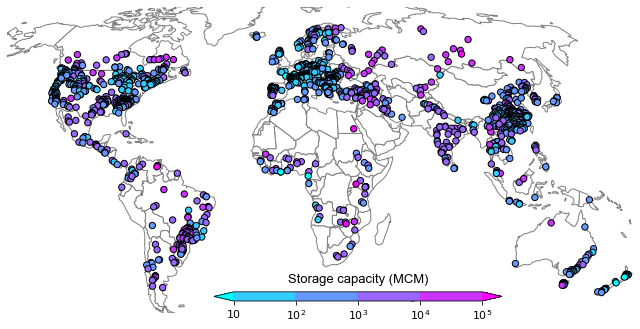

../figures/dam_capacity.png is saved.


In [21]:
# Merge Geodataframe of dam and Series of data we want to plot
damMap = gdfDam.merge(df_var['CAP'], on='GRAND_ID')
# Colormap
bounds = [10**1, 10**2, 10**3, 10**4, 10**5]
boundaries = [0]+bounds+[10**6]
cmap, norm, vmin, vmax, ticks, boundaries = cbarpam(bounds, 'cool', labloc='on', 
                                                    boundaries=boundaries, extension='both')
# Plotting
fig, ax = plt.subplots(figsize=(9,6), facecolor='w')
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis(lims)
world.plot(ax=ax, color='white', edgecolor='gray')
damMap.plot(ax=ax, column='CAP',markersize=40, edgecolor='black', 
            cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
plt.tight_layout()
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(0.33, 0.04, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels([r'$10$',r'$10^2$',r'$10^3$',r'$10^4$',r'$10^5$'], 
                        fontname='arial', fontsize=11)
cbar.set_label('Storage capacity (MCM)', labelpad=-48, 
               fontname='arial', fontsize=13, 
               horizontalalignment='center')
plt.show()
# Save a figure
if True:
    fn_save = '../figures/dam_capacity.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### Classification of 1,593 dams

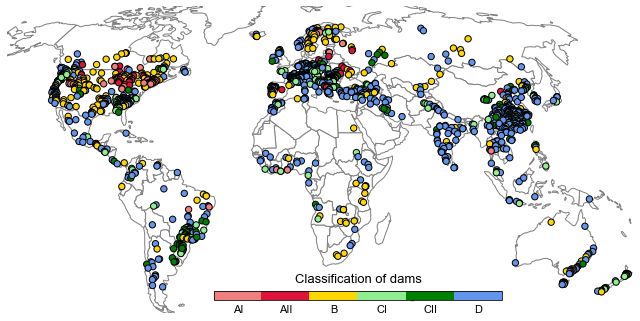

../figures/dam_class.png is saved.


In [22]:
# Merge Geodataframe of dam and Series of data we want to plot
damMap = gdfDam.merge(DamClass, on='GRAND_ID')
# Colormap
colorsList = ['lightcoral','crimson', 
              'gold', 
              'lightgreen', 'green',
              'cornflowerblue']
bounds = [0.5,1.5,2.5,3.5,4.5,5.5,6.5]
cmap, norm, _, _, ticks, boundaries = cbarpam(bounds, colorsList, labloc='in',
                                                    boundaries=bounds, extension=None)
# cmap = plt.get_cmap('cool', 6)
# Plotting
fig, ax = plt.subplots(figsize=(9,6), facecolor='w')
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis(lims)
world.plot(ax=ax, color='white', edgecolor='gray')
damMap.plot(ax=ax, column='class',markersize=40, edgecolor='black', 
            cmap=cmap, norm=norm)
plt.tight_layout()
# Colorbar
cax = inset_axes(ax,width="46%",height="3%",loc='lower left',
                 bbox_to_anchor=(0.33, 0.04, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                 boundaries = boundaries,
                                 ticks=ticks,
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['AI','AII','B','CI','CII','D'], 
                        fontname='arial', fontsize=11)
cbar.ax.tick_params(length=0)
cbar.set_label('Classification of dams', labelpad=-41, 
               fontname='arial', fontsize=13, 
               horizontalalignment='center')
plt.show()
# Save a figure
if True:
    fn_save = '../figures/dam_class.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### Prediction performances
(a) The number of months predicted and weighted KGE for 3 lead-months (MP1-3 models)\
(b) KGE and weighted KGE for 3 lead-months (MP1-3 models)

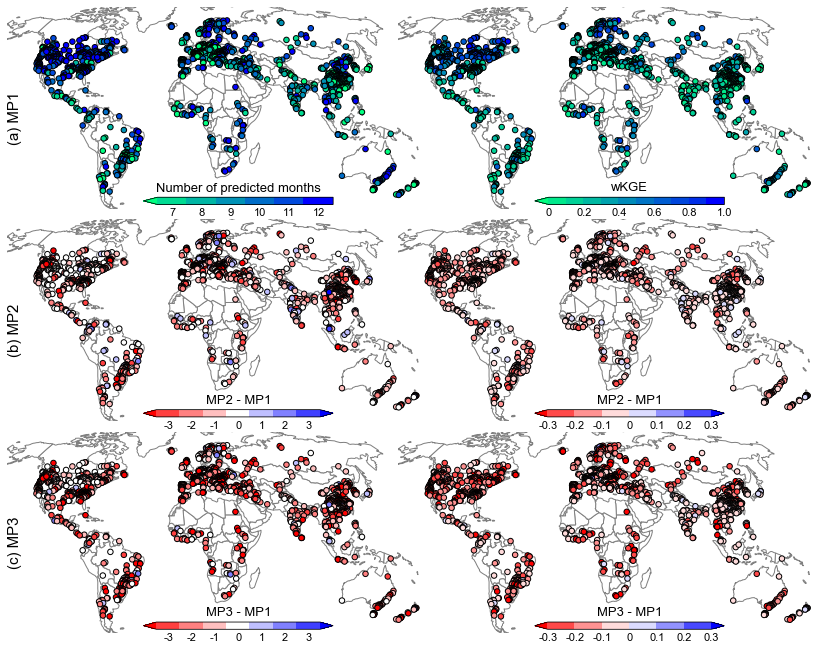

../figures/dam_pmonth_wkge.png is saved.


In [23]:
# (a) The number of months predicted and weighted KGE for 3 lead-months (MP1-3 models)
# Merge Geodataframe of dam and Series of data we want to plot
damMap = gdfDam.merge(subset, on='GRAND_ID')

# Colormaps
# (1) Number of predicted months of MP1
bounds1 = list(np.arange(6.5,13.5,1))
boundaries1 = [0] + bounds1
cmap1, norm1, vmin1, vmax1, ticks1, boundaries1 = cbarpam(bounds1, 'winter_r', labloc='in',
                                                          boundaries=boundaries1, extension='min')
# (2) Difference of number of predicted months from MP1
bounds2 = list(np.arange(-3.5,4.5,1))
boundaries2 = [-10]+bounds2+[10]
cmap2, norm2, vmin2, vmax2, ticks2, boundaries2 = cbarpam(bounds2, 'bwr_r', labloc='in',
                                                          boundaries=boundaries2, extension='both')
# (3) wKGE of MP1
bounds3 = list(np.arange(0,1.1,0.1))
boundaries3 = [-0.1]+bounds3
cmap3, norm3, vmin3, vmax3, ticks3, boundaries3 = cbarpam(bounds3, 'winter_r', labloc='on',
                                                          boundaries=boundaries3, extension='min')
# (4) Difference of wKGE from MP1
bounds4 = list(np.arange(-0.3,0.4,0.1))
boundaries4 = [-1]+bounds4+[1]
cmap4, norm4, vmin4, vmax4, ticks4, boundaries4 = cbarpam(bounds4, 'bwr_r', labloc='on',
                                                          boundaries=boundaries4, extension='both')

# Plotting
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(12,9), facecolor='w')
figLabel = ['(a) MP1','(b) MP2','(c) MP3']
colList = ['t1','t12','t13','wkge1','wkge12','wkge13']
for (i, el) in enumerate(colList):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    world.plot(ax=ax, color='white', edgecolor='gray')
    if i == 0:
        damMap.plot(ax=ax, column=el, markersize=30, edgecolor='black', 
                    cmap=cmap1, norm=norm1, vmin=vmin1, vmax=vmax1)
    elif i == 1 or i == 2:
        damMap.plot(ax=ax, column=el, markersize=30, edgecolor='black',
                    cmap=cmap2, norm=norm2, vmin=vmin2, vmax=vmax2)
    elif i == 3:
        damMap.plot(ax=ax, column=el, markersize=30, edgecolor='black', 
                    cmap=cmap3, norm=norm3)
    else:
        damMap.plot(ax=ax, column=el, markersize=30, edgecolor='black',
                    cmap=cmap4, norm=norm4, vmin=vmin4, vmax=vmax4)
    if i < 3:
        ax.annotate(figLabel[i], xy=(0.02, 0.45), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=15,rotation=90)
plt.tight_layout(w_pad=-5)
# Colorbars
for i in range(6):
    ax = axes.flatten('F')[i]
    cax = inset_axes(ax, width="46%", height="3%", loc='lower left',
                     bbox_to_anchor=(0.33, 0.02, 1, 1.2),
                     bbox_transform=ax.transAxes,
                     borderpad=0)
    if i == 0:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap1, norm=norm1,
                                         boundaries=boundaries1,
                                         extend='min',
                                         extendfrac=0.08,
                                         ticks = ticks1,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%d'%lb for lb in ticks1]
        clabel = 'Number of predicted months'
    elif i == 1 or i==2:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap2, norm=norm2,
                                         boundaries=boundaries2,
                                         extend='both',
                                         extendfrac=0.08,
                                         ticks = ticks2,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%d'%lb for lb in ticks2]
        if i == 1:
            clabel = 'MP2 - MP1'
        else:
            clabel = 'MP3 - MP1'
    elif i == 3:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap3, norm=norm3,
                                         boundaries=boundaries3,
                                         extend='min',
                                         extendfrac=0.08,
                                         ticks = ticks3,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%.1f'%lb for lb in ticks3]
        tlabel[0] = '0'; tlabel = np.array(tlabel); tlabel[1::2] = ''
        clabel = 'wKGE'
    else:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap4, norm=norm4,
                                         boundaries=boundaries4,
                                         extend='both',
                                         extendfrac=0.08,
                                         ticks = ticks4,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%.1f'%lb for lb in ticks4]
        tlabel[3] = '0'
        if i == 4:
            clabel = 'MP2 - MP1'
        else:
            clabel = 'MP3 - MP1'
    cbar.ax.set_xticklabels(tlabel, fontname='arial', fontsize=11)
    cbar.ax.tick_params(length=0)
    cbar.set_label(clabel, labelpad=-36, 
                   fontname='arial', fontsize=13, 
                   horizontalalignment='center')
plt.show()
# Save a figure
if True:
    fn_save = '../figures/dam_pmonth_wkge.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

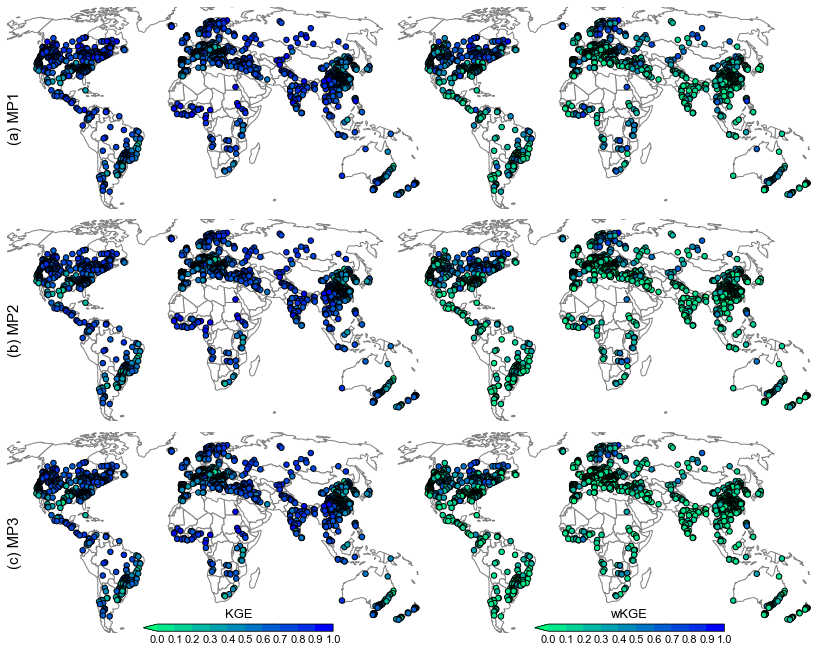

../figures/dam_kge_wkge.png is saved.


In [24]:
# (b) KGE and weighted KGE for 3 lead-months (MP1-3 models)
# Merge Geodataframe of dam and Series of data we want to plot
damMap = gdfDam.merge(subset, on='GRAND_ID')
# Colormap
# wKGE
bounds = list(np.arange(0,1.1,0.1))
boundaries = [-0.1]+bounds
cmap, norm, vmin, vmax, ticks, boundaries = cbarpam(bounds, 'winter_r', labloc='on',
                                                    boundaries=boundaries, extension='min')
# Plotting
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(12,9), facecolor='w')
figLabel = ['(a) MP1','(b) MP2','(c) MP3']
for (i, el) in enumerate(df_kge.columns):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    world.plot(ax=ax, color='white', edgecolor='gray')
    damMap.plot(ax=ax, column=el, markersize=30, edgecolor='black', 
                cmap=cmap, norm=norm, vmin=bounds[0], vmax=bounds[-1])
    if i<3:
        ax.annotate(figLabel[i], xy=(0.02, 0.45), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=15,rotation=90)
plt.tight_layout(w_pad=-5)
# Colorbar
for i in [2,5]:
    ax = axes.flatten('F')[i]
    cax = inset_axes(ax,
                     width="46%",
                     height="3%",
                     loc='lower left',
                     bbox_to_anchor=(0.33, 0.01, 1, 1.2),
                     bbox_transform=ax.transAxes,
                     borderpad=0)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                     boundaries=[-0.1]+bounds,
                                     ticks = bounds,
                                     extend='min',
                                     extendfrac=0.08,
                                     spacing='uniform',
                                     orientation='horizontal')
    cbar.ax.set_xticklabels(['%.1f'%lab for lab in bounds], 
                            fontname='arial', fontsize=11)
    cbar.ax.tick_params(length=0)
    if i == 2:
        label = 'KGE'
    elif i==5:
        label = 'wKGE'   
    cbar.set_label(label, labelpad=-36, 
                   fontname='arial', fontsize=13, 
                   horizontalalignment='center')
plt.show()
# Save a figure
if True:
    fn_save = '../figures/dam_kge_wkge.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### Improvements of hydropower production
The improvements are defined as:
<img src="https://latex.codecogs.com/svg.latex?\Large&space;I_{PF}=\frac{MPC_{PF}-SDP}{MPC_{PF}}\times100\%" />
<img src="https://latex.codecogs.com/svg.latex?\Large&space;I_{DF}=\frac{MPC_{DF}-SDP}{MPC_{PF}}\times100\%" />

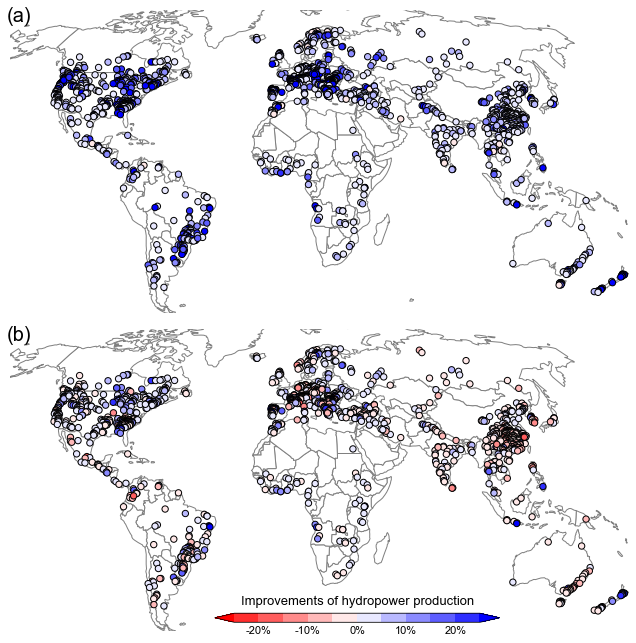

../figures/dam_improvements.png is saved.


In [25]:
# Merge Geodataframe of dam and Series of data we want to plot
damMap = gdfDam.merge(subset, on='GRAND_ID')
# Colormap
bounds = list(np.arange(-25,26,5))
boundaries = [-100]+bounds+[100]
cmap, norm, vmin, vmax, ticks, boundaries = cbarpam(bounds, 'bwr_r', labloc='on', 
                                                    boundaries=boundaries, extension='both')
# Plotting
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(9,9), facecolor='w')
# Perfect forecast
ax = axes[0]
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis(lims)
world.plot(ax=ax, color='white', edgecolor='gray')
damMap.plot(ax=ax, column='PF',markersize=40, edgecolor='black', 
            cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
ax.annotate('(a)', xy=(0.015, 0.98), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontname='arial',fontsize=20)
# MPC forecast
ax = axes[1]
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis(lims)
world.plot(ax=ax, color='white', edgecolor='gray')
damMap.plot(ax=ax, column='DF',markersize=40, edgecolor='black', 
            cmap=cmap, norm=norm, vmin=bounds[0], vmax=bounds[-1])
ax.annotate('(b)', xy=(0.015, 0.98), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontname='arial',fontsize=20)
plt.tight_layout()
# Colorbar
cax = inset_axes(ax,
                 width="46%",
                 height="3%",
                 loc='lower left',
                 bbox_to_anchor=(0.33, 0.03, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = bounds[1::2],
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels([str(lab)+'%' for lab in bounds[1::2]], 
                        fontname='arial', fontsize=11)
cbar.ax.tick_params(length=0)
cbar.set_label('Improvements of hydropower production', labelpad=-41, 
               fontname='arial', fontsize=13, 
               horizontalalignment='center')
plt.show()
# Save a figure
if True:
    fn_save = '../figures/dam_improvements.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### Improvements and prediction skill
Scatterplot of KGE and wKGE\
Scatterplot of dam classification and wKGE with Boxplot of improvements for dam types

In [26]:
temp = subset[['PF','DF','nkge1','wkge1']]
temp = temp.merge(DamClass, on='GRAND_ID')
temp.head()

,PF,DF,nkge1,wkge1,class
GRAND_ID,,,,,
6,1.626019,-2.786552,0.733003,0.461472,6.0
24,12.273002,0.065350,0.659730,0.288042,5.0
25,5.776703,-5.635491,0.659730,0.288042,6.0
27,2.815570,2.227625,0.585621,0.147263,6.0
31,8.445336,-1.468108,0.707275,0.109649,6.0


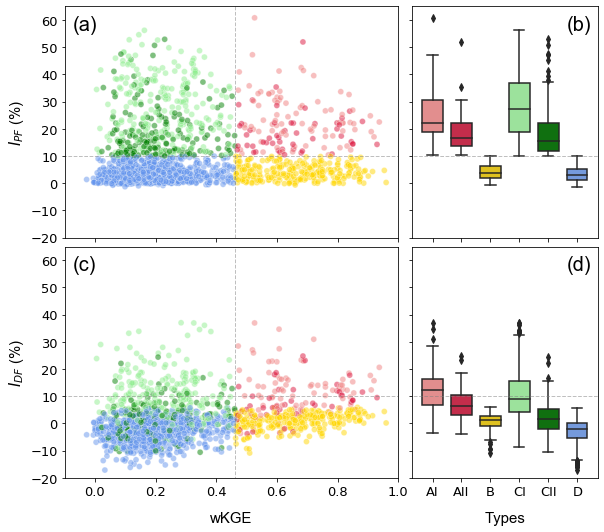

../figures/impv_classification.png is saved.


In [27]:
temp = subset[['PF','DF','nkge1','wkge1']]
temp = temp.merge(DamClass, on='GRAND_ID')

# Colormap
colorsList = ['lightcoral','crimson', 
              'gold', 
              'lightgreen', 'green',
              'cornflowerblue']
cmap = colors.ListedColormap(colorsList)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8.5,7.5), 
                         sharey=True, sharex=False,
                         gridspec_kw={'width_ratios':[1.8,1]})

# (a) Scatterplot of PF and wKGE
ax = axes.flatten('C')[0]
sc = sns.scatterplot(data=temp, x='wkge1', y='PF', ax=ax, marker='o', 
                     linewidth=0.5, alpha=0.5, palette=cmap,
                     hue='class', hue_norm=(1, 6))
ax.plot([-1, 1], [10, 10], color='grey', lw=1, alpha=0.5, linestyle='--')
ax.plot([0.463, 0.463], [-100, 100], color='grey', lw=1, alpha=0.5, linestyle='--')
ax.get_legend().remove()
sc.tick_params(labelsize=13)
ax.yaxis.set_tick_params(which='both', labelbottom=True)
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_yticks(np.arange(-20,65,10))
ax.set_ylabel(r'$I_{PF}$ (%)', fontsize=15, fontname='arial')
ax.set_xlim([-0.1, 1])
ax.set_ylim([-20, 65])
ax.annotate('(a)', xy=(0.06, 0.92), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontname='arial',fontsize=20)
# (b) Boxplot of PF and classifications
ax = axes.flatten('C')[1]
sc = sns.boxplot(data=impv6P, ax=ax, width=0.7, palette=colorsList)
sc.plot([-10, 10], [10, 10], color='grey', lw=1, alpha=0.5, linestyle='--')
sc.tick_params(labelsize=13)
sc.set_xlim([-0.7, 5.7])
ax.set_xticklabels([])
ax.annotate('(b)', xy=(0.90, 0.92), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontname='arial',fontsize=20)
# (c) Scatterplot of PF and wKGE
ax = axes.flatten('C')[2]
sc = sns.scatterplot(data=temp, x='wkge1', y='DF', ax=ax, marker='o', 
                     linewidth=0.5, alpha=0.5, palette=cmap, 
                     hue='class', hue_norm=(1, 6))
sc.tick_params(labelsize=12)
ax.set_xlim([-0.1, 1])
ax.plot([-1, 1], [10, 10], color='gray', lw=1, alpha=0.5, linestyle='--')
ax.plot([0.463, 0.463], [-100, 100], color='gray', lw=1, alpha=0.5, linestyle='--')
ax.get_legend().remove()
ax.tick_params(labelsize=13)
ax.set_ylabel(r'$I_{DF}$ (%)', fontsize=15, fontname='arial')
ax.set_xlim([-0.1, 1])
ax.set_ylim([-20, 65])
ax.set_xlabel('wKGE', fontname='arial', fontsize=15,
              horizontalalignment='center', labelpad = 13)
ax.annotate('(c)', xy=(0.06, 0.92), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontname='arial',fontsize=20)
# (d) Boxplot of PF and classifications
ax = axes.flatten('C')[3]
sc = sns.boxplot(data=impv6D, ax=ax, width=0.7, palette=colorsList)
sc.plot([-10, 10], [10, 10], color='gray', lw=1, alpha=0.5, linestyle='--')
ax.set_xlabel('Types', fontname='arial', fontsize=15,
             horizontalalignment='center', labelpad = 13)
sc.tick_params(labelsize=13)
sc.set_xlim([-0.7, 5.7])
ax.annotate('(d)', xy=(0.90, 0.92), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontname='arial',fontsize=20)

plt.tight_layout(w_pad=0.02, h_pad=0.1)
plt.show()
# Save a figure
if True:
    fn_save = '../figures/impv_classification.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)